In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'email-spam-classification-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3962399%2F6897944%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240126%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240126T113549Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D67cf6a1ff1118384a95058f9dd59d3b98625024328c3f700f74260ce3ce711d5377d10128c62fee99756fc24364d2297f458df3e2c60a5d397a02ae8a3fa540ac75ce89000eb6f2d252938c9f83a06891a38a3c48d424128eacfca130daf481758217abee180e2904aa96cae0eac6ea69e7cc4a675892e8982a0046f84de957a77965c950e01b38c78569f958eac90a5887deea4e56c14d6f682518579b933213f17a1a1c874f152990fddb6d8bd2410633de11f13ff966495bd60d7efc865e957a24e0b415e7da109eae6988506f609cc43a4213a0a0f8b46d8f2da1ee07677b5a23f37b7616c9436fbed8eeb8acf5ad3616ed8102fd696a1b7aae665e14ecd'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 45062184 bytes downloaded
Downloaded and uncompressed: email-spam-classification-dataset
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import nltk
import numpy as np
import pandas as pd
nltk.download('punkt')
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/kaggle/input/email-spam-classification-dataset/combined_data.csv


In [3]:
df = pd.read_csv('/kaggle/input/email-spam-classification-dataset/combined_data.csv')
df.head()

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...


In [ ]:
df.isna().sum()

label    0
text     0
dtype: int64

In [ ]:
df.describe()

,label
count,83448.000000
mean,0.526196
std,0.499316
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83448 entries, 0 to 83447
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   83448 non-null  int64 
 1   text    83448 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


In [ ]:
df['label'].value_counts()

1    43910
0    39538
Name: label, dtype: int64

In [ ]:
df.shape

(83448, 2)

In [ ]:
print("Number of duplicates: ",df.duplicated().sum())

Number of duplicates:  0


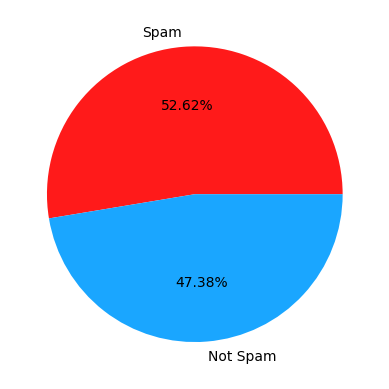

In [4]:
labels = ['Spam','Not Spam']
plt.pie(x=df['label'].value_counts(),labels=labels,autopct='%.2f%%',colors=['#FF1A1A','#1AA6FF'])
plt.show()

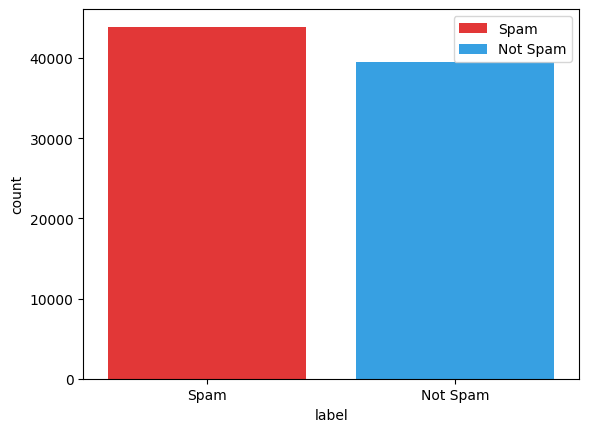

In [5]:
labels = df['label'].map({0:'Not Spam',1:'Spam'})
colors=['#FF1A1A','#1AA6FF']
sb.countplot(data=df,x=labels,hue=labels,palette=colors)
plt.legend(labels.unique())
plt.show()

In [ ]:
df['num_characters'] = df['text'].apply(len)
df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))
df['num_sentence'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))
df.sample(5)

,label,text,num_characters,num_words,num_sentence
69349,1,any software backups for lowest pricest .\nwhe...,155,30,3
20625,1,email loading . . . )\nbuy your m - e - d - i ...,68,25,4
66071,1,a fly and a flea in a flue\na fly and a flea i...,322,69,5
70507,0,hello everyone i'm a perl beginner and i've be...,4711,764,1
44380,1,no risk pharmectucal products at reduced cost ...,67,11,1


In [ ]:
df[['num_characters','num_words','num_sentence']].describe()

,num_characters,num_words,num_sentence
count,83448.000000,83448.000000,83448.000000
mean,1662.952725,285.022733,7.250060
std,4178.578068,727.032941,34.832317
min,1.000000,1.000000,1.000000
25%,449.000000,80.000000,1.000000
50%,879.000000,154.000000,1.000000
75%,1861.000000,314.000000,5.000000
max,598705.000000,101984.000000,3093.000000


In [ ]:
df[df['label'] == 0][['num_characters','num_words','num_sentence']].describe()

,num_characters,num_words,num_sentence
count,39538.000000,39538.000000,39538.000000
mean,2121.693814,367.659467,8.137362
std,5666.075286,986.766959,42.112956
min,1.000000,1.000000,1.000000
25%,579.000000,107.000000,1.000000
50%,1139.000000,202.000000,1.000000
75%,2174.000000,381.000000,6.000000
max,598705.000000,101984.000000,2827.000000


In [ ]:
df[df['label'] == 1][['num_characters','num_words','num_sentence']].describe()

,num_characters,num_words,num_sentence
count,43910.000000,43910.000000,43910.000000
mean,1249.887247,210.613915,6.451105
std,1978.631507,340.723605,26.599623
min,1.000000,1.000000,1.000000
25%,360.000000,62.000000,1.000000
50%,704.000000,122.000000,1.000000
75%,1510.000000,250.000000,5.000000
max,144087.000000,25444.000000,3093.000000


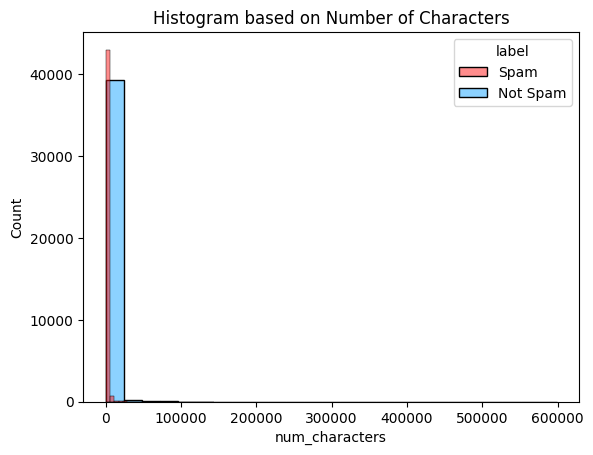

In [ ]:
plt.title("Histogram based on Number of Characters")
sb.histplot(data=df,x=df[df['label']==0]['num_characters'],bins=25,hue=labels,palette=colors)
sb.histplot(data=df,x=df[df['label']==1]['num_characters'],bins=25,hue=labels,palette=colors)

plt.show()

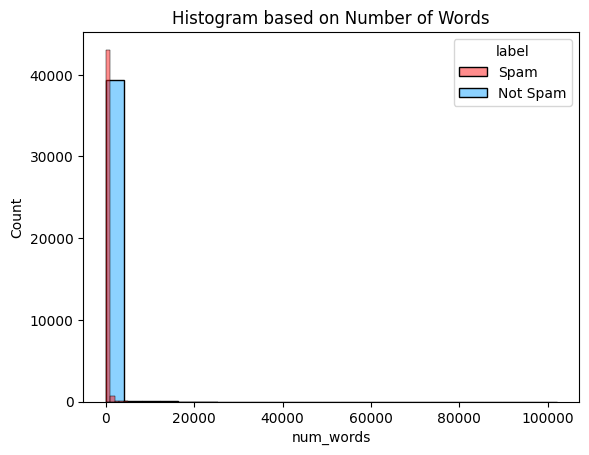

In [ ]:
plt.title('Histogram based on Number of Words')
sb.histplot(data=df,x=df[df['label']==0]['num_words'],bins=25,hue=labels,palette=colors,legend=True)
sb.histplot(data=df,x=df[df['label']==1]['num_words'],bins=25,hue=labels,palette=colors,legend=True)

plt.show()

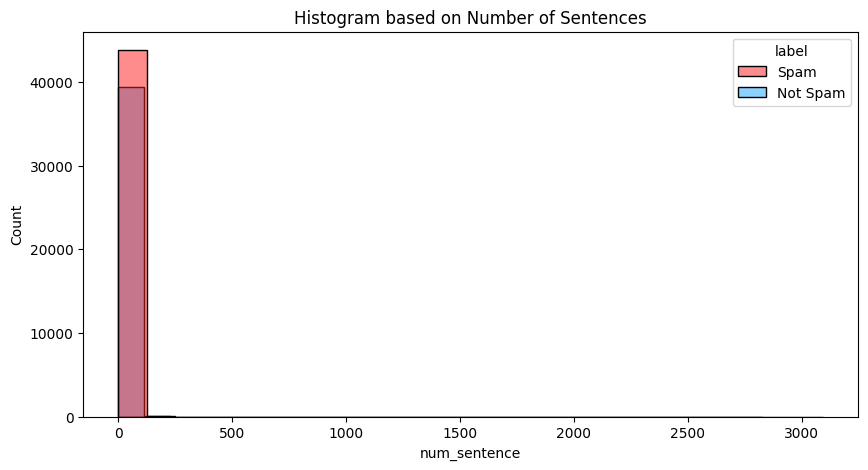

In [ ]:
plt.figure(figsize=[10,5])
plt.title('Histogram based on Number of Sentences')
sb.histplot(data=df,x=df[df['label']==0]['num_sentence'],bins=25,hue=labels,palette=colors,legend=True)
sb.histplot(data=df,x=df[df['label']==1]['num_sentence'],bins=25,hue=labels,palette=colors,legend=True)
plt.show()

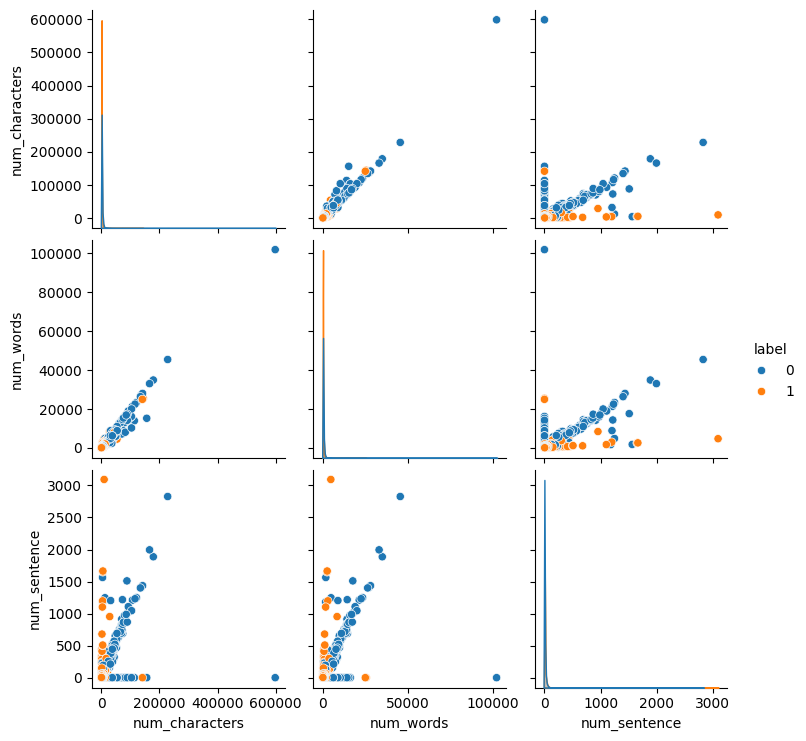

In [ ]:
sb.pairplot(df,hue="label")

<Axes: >

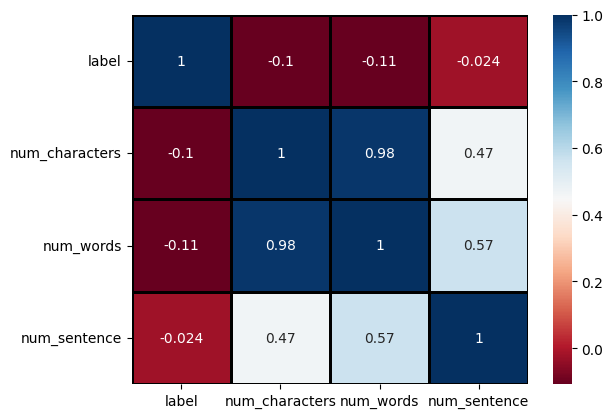

In [ ]:
df2 = df.drop('text',axis=1)
sb.heatmap(df2.corr(),annot=True,cmap='RdBu',linewidths=1,linecolor='black')

In [ ]:
x = df['text'].values
y = df['label'].values

In [ ]:
v = CountVectorizer()
x_transf = v.fit_transform(x.reshape(-1))


In [ ]:
print(v.get_feature_names_out().max())
print(len(v.get_feature_names_out()))

李俊杰
310813


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_transf,y,test_size=0.2,random_state=100,stratify=y)

In [ ]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

mnb = MultinomialNB()
bnb = BernoulliNB()

In [ ]:

mnb.fit(x_train,y_train)
bnb.fit(x_train,y_train)


mnb_pred = mnb.predict(x_test)
bnb_pred = bnb.predict(x_test)


print('Classification report of MultinomialNB: ')
print('\n')
print(classification_report(y_test,mnb_pred,target_names=['Not Spam','Spam']))

print('Classification report of BernoulliNB: ')
print('\n')
print(classification_report(y_test,bnb_pred,target_names=['Not Spam','Spam']))


Classification report of MultinomialNB: 


              precision    recall  f1-score   support

    Not Spam       0.97      0.98      0.98      7908
        Spam       0.99      0.97      0.98      8782

    accuracy                           0.98     16690
   macro avg       0.98      0.98      0.98     16690
weighted avg       0.98      0.98      0.98     16690

Classification report of BernoulliNB: 


              precision    recall  f1-score   support

    Not Spam       0.95      0.89      0.92      7908
        Spam       0.91      0.96      0.93      8782

    accuracy                           0.93     16690
   macro avg       0.93      0.93      0.93     16690
weighted avg       0.93      0.93      0.93     16690



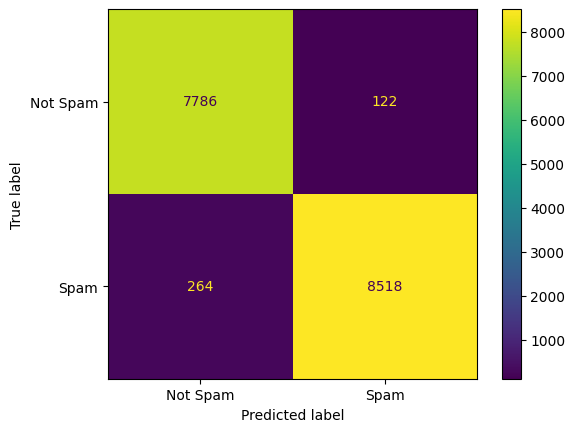

In [ ]:
cfm = confusion_matrix(y_test,mnb_pred,labels=mnb.classes_)
disp = ConfusionMatrixDisplay(cfm,display_labels=['Not Spam','Spam'])
disp.plot()

In [ ]:
msg = ["Congrats you won an iPhone grab it before it's too late."]
msg_transf = v.transform(msg)
pred = mnb.predict(msg_transf)
if pred == 1:
  print('Spam')
else:
  print('Not Spam')

Spam


In [ ]:
msg = ["Hey Sam, Let's go party tonight"]
msg_transf = v.transform(msg)
pred = mnb.predict(msg_transf)
if pred == 1:
  print('Spam')
else:
  print('Not Spam')

Not Spam


In [ ]:
from joblib import dump

dump(mnb,'Spam_model.joblib')
dump(v,'transformer.joblib')

['transformer.joblib']